In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

#from utils import mnist, plot_graphs, plot_mnist
import numpy as np
import os 

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


In [2]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
           ])

def mnist(batch_size=50, valid=0, shuffle=True, transform=mnist_transform, path='./MNIST_data'):
    test_data = datasets.MNIST(path, train=False, download=True, transform=transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    train_data = datasets.MNIST(path, train=True, download=True, transform=transform)
    if valid > 0:
        num_train = len(train_data)
        indices = list(range(num_train))
        split = num_train-valid
        np.random.shuffle(indices)

        train_idx, valid_idx = indices[:split], indices[split:]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
        valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
    
        return train_loader, valid_loader, test_loader
    else:
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        return train_loader, test_loader


def plot_mnist(images, shape, show=True, save_to=None):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))

    if save_to is not None:
        plt.savefig(save_to)
        
    if show:
        plt.show()
    else:
        plt.close()

    
def plot_graphs(log, tpe='loss'):
    keys = log.keys()
    logs = {k:[z for z in zip(*log[k])] for k in keys}
    epochs = {k:range(len(log[k])) for k in keys}
    
    if tpe == 'loss':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][0], label=k) for k in keys])
        plt.title('errors')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend(handles=handlers)
        plt.show()
    elif tpe == 'accuracy':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label=k) for k in log.keys()])
        plt.title('accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(handles=handlers)
        plt.show()
        
def to_onehot(x, n, device=None):
    if isinstance(x, np.ndarray):
        x = torch.Tensor(x).to(torch.long)
    one_hot = torch.zeros((x.shape[0], n))
    one_hot.scatter_(1, x[:, None], 1.)
    if device is not None:
        one_hot = one_hot.to(device)
    return one_hot

In [3]:
root_folder = 'FC_VAE_log_results'
fixed_folder = root_folder + '/Fixed_results'
AE_folder = root_folder + '/AE_results'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)
os.mkdir(AE_folder)

In [4]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

In [5]:
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_tanh)
fixed_z = torch.randn((50, 2))
fixed_data, _ = next(iter(test_loader))

In [6]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, last_fn=None):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        return self.model(x)

In [7]:
class Net(nn.Module):
    def __init__(self, latent_size=32, gamma=1e-3, batchnorm=False, dropout=False, optim_type='SGD', **optim_params):
        super(Net, self).__init__()
    
        self.latent_size = latent_size
        self.gamma = gamma

        self.fce = FullyConnected([784, 512, 128, latent_size*2], activation_fn=nn.ReLU(), flatten=True)
        self.fcd = FullyConnected([latent_size*2, 128, 512, 784], activation_fn=nn.ReLU())
        
        self._loss = None
        if optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)
    
    def forward(self, x):
        h = self.fce(x)
        out = self.fcd(h)
        out = out.view(-1, 1, 28, 28)
        return out
    
    def encode(self, x):
        h = self.fce(x)
        return h
    
    
    def loss(self, output, target, Discr_loss, size_average=True):
        if size_average:
            self._loss = F.mse_loss(output, target, reduction='mean')
        else:
            self._loss = F.mse_loss(output, target, reduction='sum')
        
        return self._loss + Discr_loss

In [8]:
lr = 0.0001
prior_size = 100
train_epoch = 1000
batch_size = 250
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, transform=mnist_tanh)


latent_size = 64

In [32]:
Discr = FullyConnected([64, 1024, 512, 256, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), flatten=True)

Discr_optimizer = optim.Adam(Discr.parameters(), lr=lr)

In [33]:
batch_zeros = torch.zeros((batch_size, 1))
batch_ones = torch.ones((batch_size, 1))

In [34]:
model =  Net(32, 0.005, batchnorm=True, dropout=True, optim_type='Adam', lr=1e-4 )

In [43]:
def train(epoch, model, Discr, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        # train Discr
        model.optim.zero_grad()
        #Enc.zero_grad()
        #Dec.zero_grad()
        Discr.zero_grad()
        # готовим вектора
        #z = torch.randn((batch_size, prior_size))

        
        h = model.encode(data)
        z = torch.randn((batch_size, 64))
        
        fake_pred = Discr(h)
        true_pred = Discr(z)
        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        Discr_loss = 0.5*(fake_loss + true_loss)
        
        Discr_loss.backward(retain_graph=True)
        Discr_optimizer.step()
        
        # train AutoENC
        
        Discr.zero_grad()
        model.optim.zero_grad()
        
        output = model(data)
        loss = model.loss(output, data, Discr_loss)
        loss.backward()
        model.optim.step()


            
        if batch_idx % 200 == 0:
            print(batch_idx,loss,Discr_loss)
            
    

In [44]:
def test(model, D, loader, epoch, log=None):
    test_size = len(loader)
    model_loss = 0.
    Discr_loss = 0.
    test_loss = {'M': 0., 'D': 0.}
    with torch.no_grad():
        for data, _ in loader:
            z = torch.randn((batch_size, 64))
            h = model.encode(data)
            fake_pred = Discr(h)
            true_pred = Discr(z)
        
            fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros).item()
            true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones).item()
            
            Discr_loss += 0.5*(fake_loss + true_loss)
            output = model(data)
            model_loss += model.loss(output, data, Discr_loss)
    
    model_loss /= test_size
    Discr_loss /= test_size

    fixed_gen = model(fixed_z).data.numpy().reshape(50, 1, 28, 28)
    plot_mnist(fixed_gen, (5, 10), True, fixed_folder + '/%03d.png' % epoch)
    report = 'Test losses. model_loss: {:.4f}, Discr_loss: {:.4f}'.format(model_loss, Discr_loss)
    print(report)

In [45]:
train_log = {'G': [], 'D': []}
test_log = {'G': [], 'D': []}

fixed_z = torch.randn((50, 28*28))
print(fixed_z)
#fixed_z = torch.randn((50, 2))
fixed_data, _ = next(iter(test_loader))

tensor([[-9.6202e-01, -1.3338e+00,  1.2578e+00,  ..., -1.6429e-03,
          9.4329e-01, -1.8963e+00],
        [ 2.0475e+00, -1.8982e+00, -7.3785e-01,  ...,  1.6542e+00,
         -4.1223e-01,  1.0545e+00],
        [-5.4663e-01, -1.1388e+00, -7.1872e-01,  ..., -1.7633e-01,
          2.2823e-01, -4.7602e-01],
        ...,
        [ 5.6127e-01, -1.2380e+00,  6.6321e-01,  ...,  1.8108e+00,
         -2.4135e-01, -4.9754e-01],
        [ 7.6100e-01, -8.2098e-01, -5.3562e-01,  ...,  6.2052e-01,
          2.0369e+00,  1.0010e-01],
        [ 4.0365e-01,  3.0836e+00, -1.1335e-01,  ...,  1.7730e+00,
         -3.6634e-01, -7.7864e-01]])


0 tensor(0.1173, grad_fn=<AddBackward0>) tensor(3.5910e-05, grad_fn=<MulBackward0>)


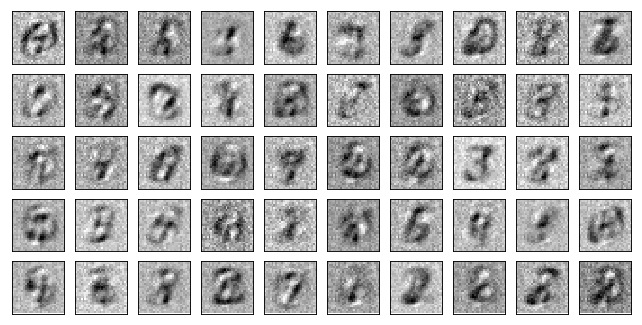

Test losses. model_loss: 0.1043, Discr_loss: 0.0000
0 tensor(0.1039, grad_fn=<AddBackward0>) tensor(1.8370e-05, grad_fn=<MulBackward0>)


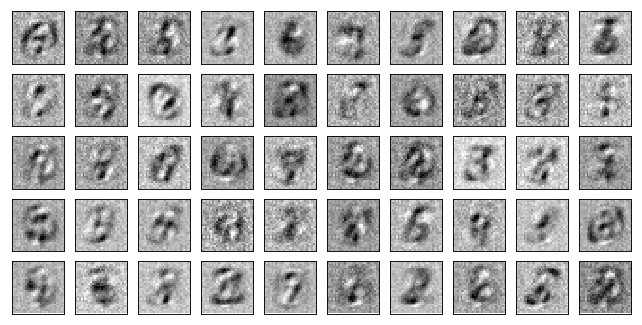

Test losses. model_loss: 0.0947, Discr_loss: 0.0000
0 tensor(0.0924, grad_fn=<AddBackward0>) tensor(1.5885e-05, grad_fn=<MulBackward0>)


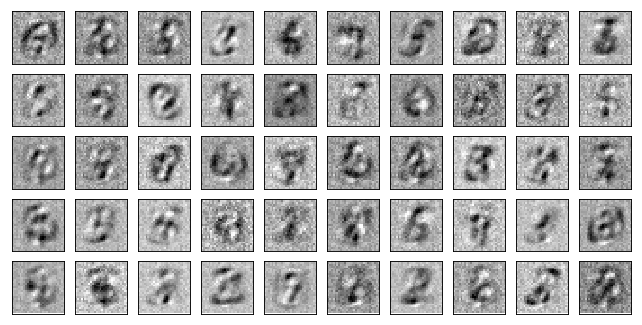

Test losses. model_loss: 0.0877, Discr_loss: 0.0000
0 tensor(0.0848, grad_fn=<AddBackward0>) tensor(7.4722e-06, grad_fn=<MulBackward0>)


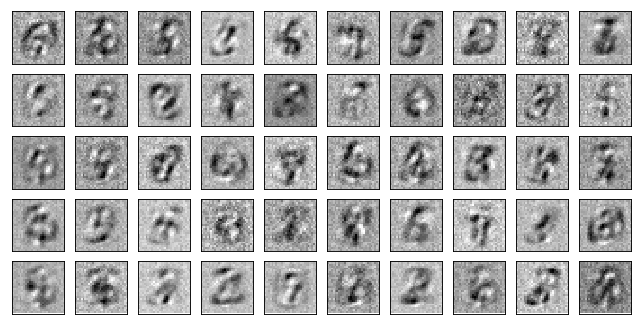

Test losses. model_loss: 0.0817, Discr_loss: 0.0000
0 tensor(0.0835, grad_fn=<AddBackward0>) tensor(1.4265e-05, grad_fn=<MulBackward0>)


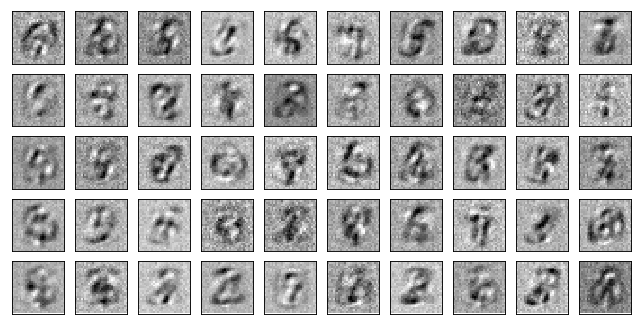

Test losses. model_loss: 0.0769, Discr_loss: 0.0000
0 tensor(0.0760, grad_fn=<AddBackward0>) tensor(6.4694e-06, grad_fn=<MulBackward0>)


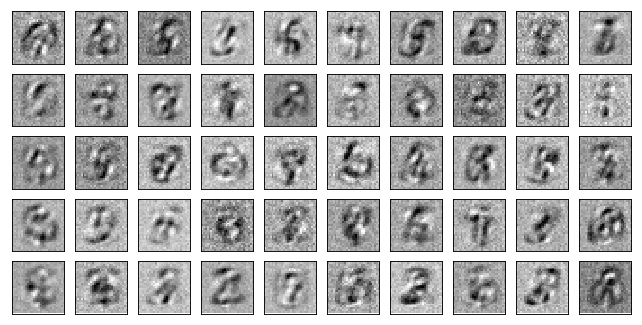

Test losses. model_loss: 0.0726, Discr_loss: 0.0000
0 tensor(0.0742, grad_fn=<AddBackward0>) tensor(4.4828e-06, grad_fn=<MulBackward0>)


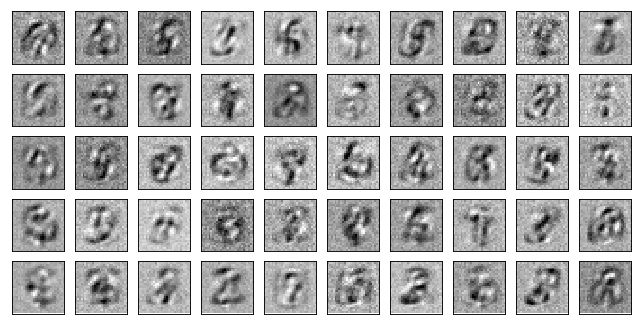

Test losses. model_loss: 0.0693, Discr_loss: 0.0000
0 tensor(0.0705, grad_fn=<AddBackward0>) tensor(3.1899e-06, grad_fn=<MulBackward0>)


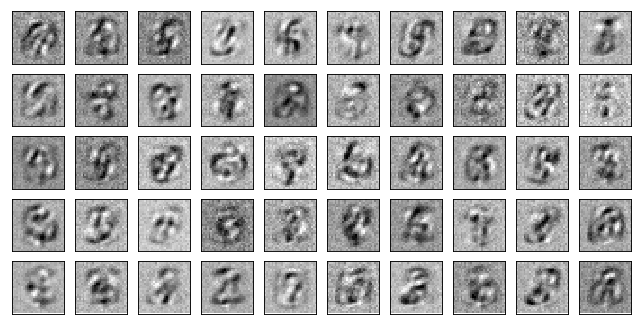

Test losses. model_loss: 0.0665, Discr_loss: 0.0000
0 tensor(0.0649, grad_fn=<AddBackward0>) tensor(3.3595e-06, grad_fn=<MulBackward0>)


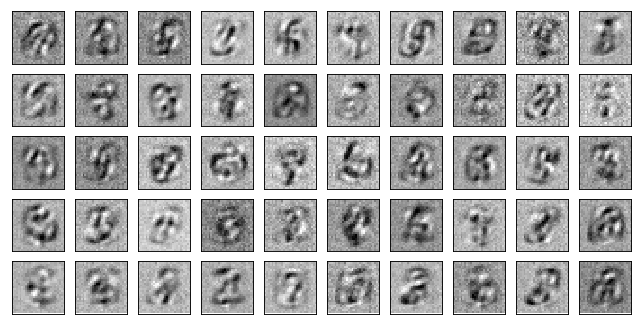

Test losses. model_loss: 0.0643, Discr_loss: 0.0000
0 tensor(0.0654, grad_fn=<AddBackward0>) tensor(2.2571e-06, grad_fn=<MulBackward0>)


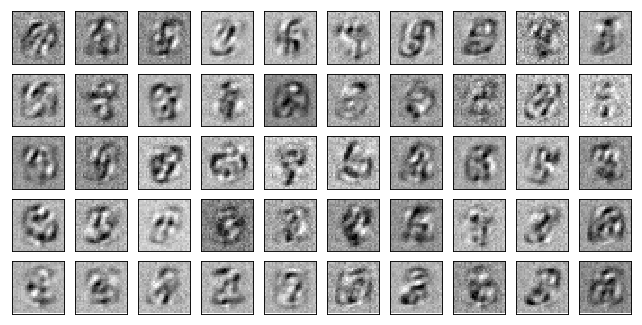

Test losses. model_loss: 0.0624, Discr_loss: 0.0000
0 tensor(0.0630, grad_fn=<AddBackward0>) tensor(2.7812e-06, grad_fn=<MulBackward0>)


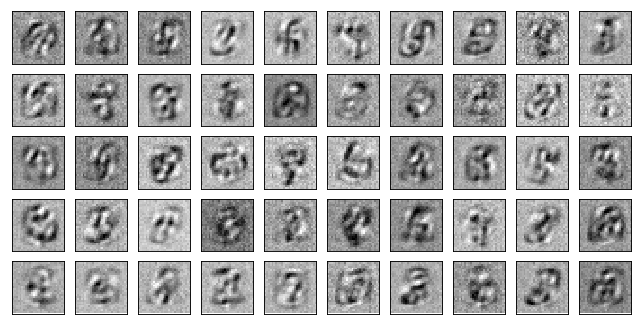

Test losses. model_loss: 0.0604, Discr_loss: 0.0000
0 tensor(0.0593, grad_fn=<AddBackward0>) tensor(2.2041e-06, grad_fn=<MulBackward0>)


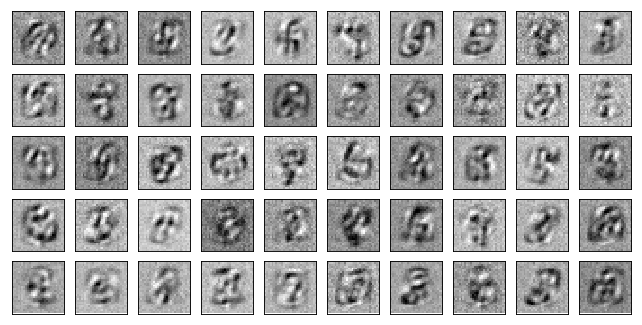

Test losses. model_loss: 0.0586, Discr_loss: 0.0000
0 tensor(0.0577, grad_fn=<AddBackward0>) tensor(1.8875e-06, grad_fn=<MulBackward0>)


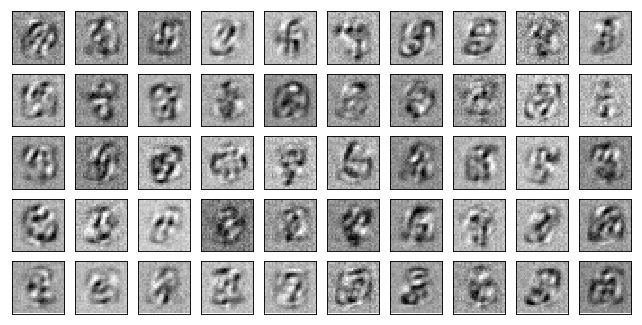

Test losses. model_loss: 0.0570, Discr_loss: 0.0000
0 tensor(0.0549, grad_fn=<AddBackward0>) tensor(2.1149e-06, grad_fn=<MulBackward0>)


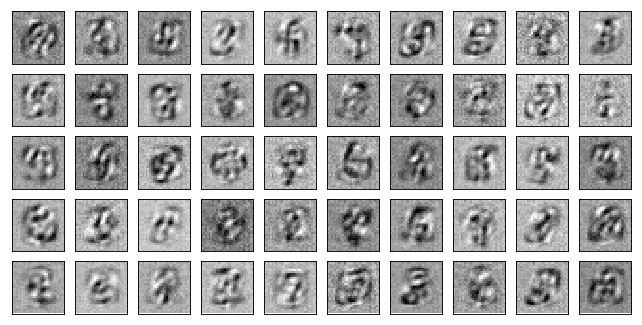

Test losses. model_loss: 0.0556, Discr_loss: 0.0000
0 tensor(0.0556, grad_fn=<AddBackward0>) tensor(1.0235e-06, grad_fn=<MulBackward0>)


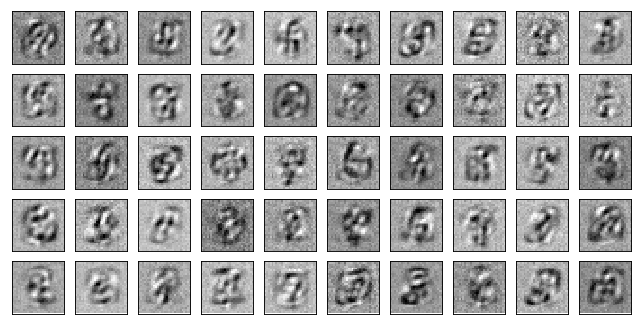

Test losses. model_loss: 0.0542, Discr_loss: 0.0000
0 tensor(0.0549, grad_fn=<AddBackward0>) tensor(9.2601e-07, grad_fn=<MulBackward0>)


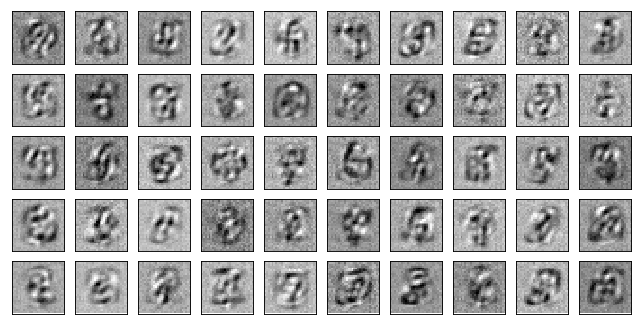

Test losses. model_loss: 0.0530, Discr_loss: 0.0000
0 tensor(0.0546, grad_fn=<AddBackward0>) tensor(1.3217e-06, grad_fn=<MulBackward0>)


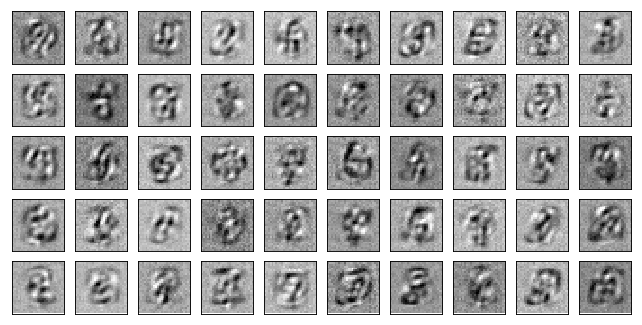

Test losses. model_loss: 0.0519, Discr_loss: 0.0000
0 tensor(0.0511, grad_fn=<AddBackward0>) tensor(1.5049e-06, grad_fn=<MulBackward0>)


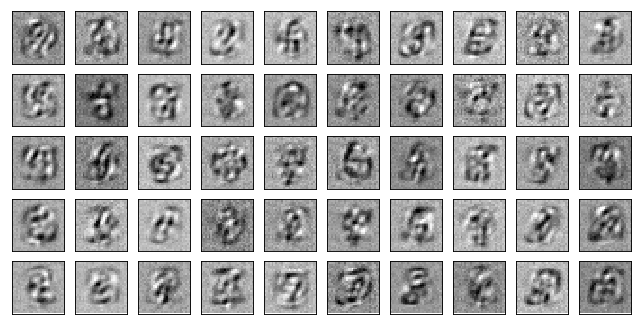

Test losses. model_loss: 0.0510, Discr_loss: 0.0000
0 tensor(0.0513, grad_fn=<AddBackward0>) tensor(5.5026e-07, grad_fn=<MulBackward0>)


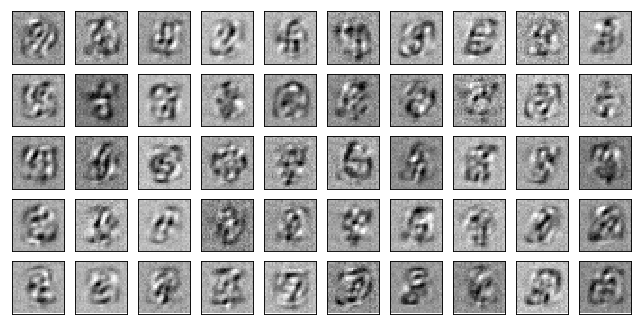

Test losses. model_loss: 0.0501, Discr_loss: 0.0000
0 tensor(0.0484, grad_fn=<AddBackward0>) tensor(3.7527e-07, grad_fn=<MulBackward0>)


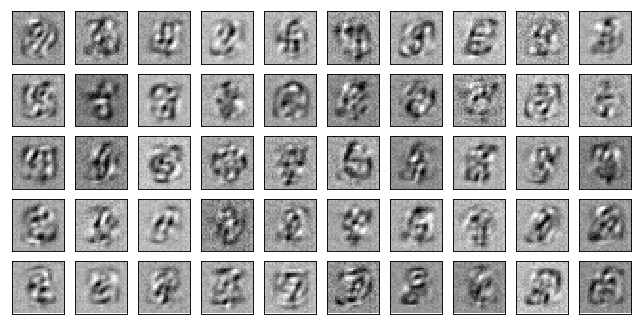

Test losses. model_loss: 0.0492, Discr_loss: 0.0000
0 tensor(0.0497, grad_fn=<AddBackward0>) tensor(1.0966e-06, grad_fn=<MulBackward0>)


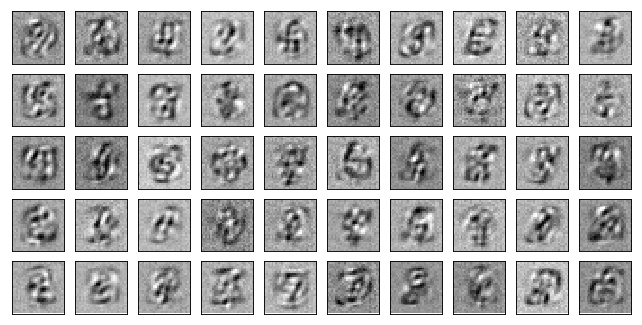

Test losses. model_loss: 0.0484, Discr_loss: 0.0000
0 tensor(0.0492, grad_fn=<AddBackward0>) tensor(4.4369e-07, grad_fn=<MulBackward0>)


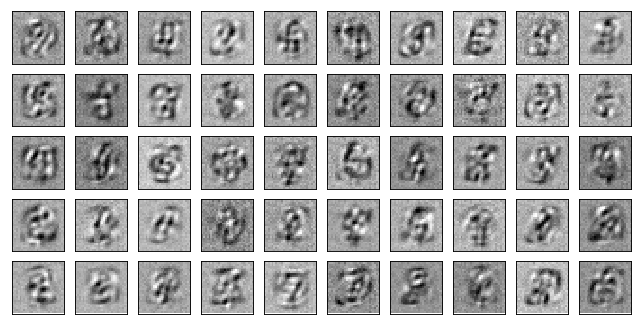

Test losses. model_loss: 0.0477, Discr_loss: 0.0000
0 tensor(0.0472, grad_fn=<AddBackward0>) tensor(4.1890e-07, grad_fn=<MulBackward0>)


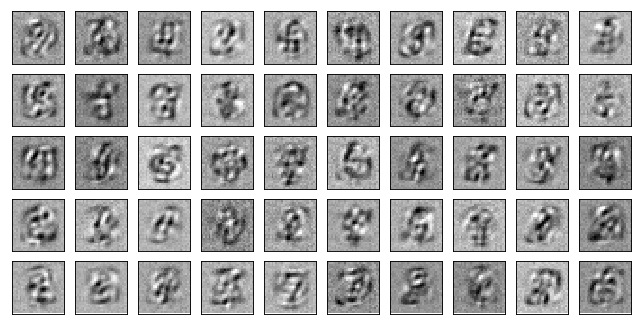

Test losses. model_loss: 0.0470, Discr_loss: 0.0000
0 tensor(0.0482, grad_fn=<AddBackward0>) tensor(2.6226e-07, grad_fn=<MulBackward0>)


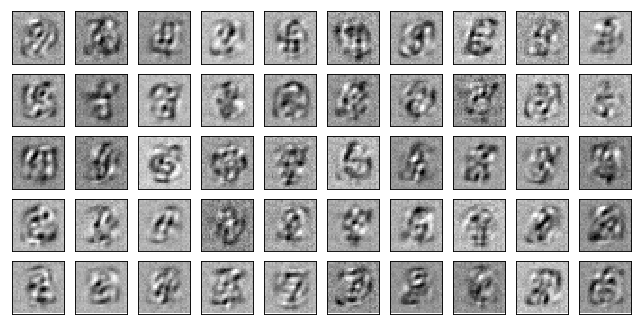

Test losses. model_loss: 0.0464, Discr_loss: 0.0000
0 tensor(0.0477, grad_fn=<AddBackward0>) tensor(3.1376e-07, grad_fn=<MulBackward0>)


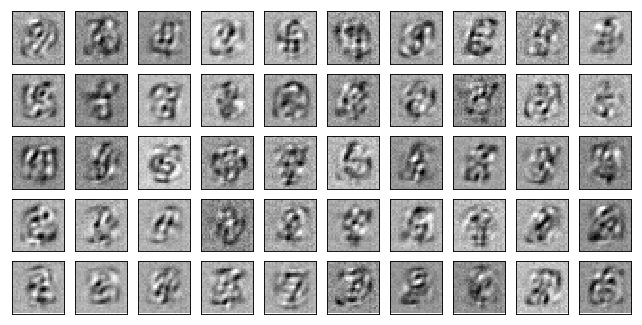

Test losses. model_loss: 0.0459, Discr_loss: 0.0000
0 tensor(0.0451, grad_fn=<AddBackward0>) tensor(1.7857e-07, grad_fn=<MulBackward0>)


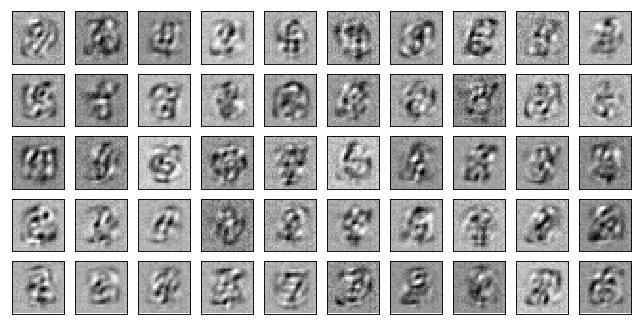

Test losses. model_loss: 0.0453, Discr_loss: 0.0000
0 tensor(0.0446, grad_fn=<AddBackward0>) tensor(4.2556e-07, grad_fn=<MulBackward0>)


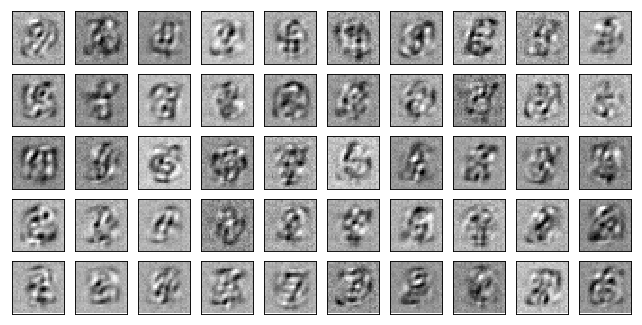

Test losses. model_loss: 0.0448, Discr_loss: 0.0000
0 tensor(0.0432, grad_fn=<AddBackward0>) tensor(1.9526e-07, grad_fn=<MulBackward0>)


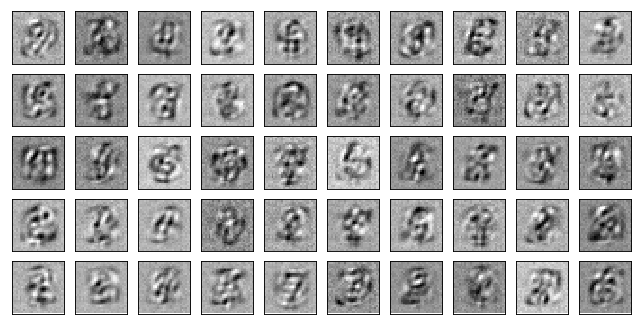

Test losses. model_loss: 0.0443, Discr_loss: 0.0000
0 tensor(0.0460, grad_fn=<AddBackward0>) tensor(1.3137e-07, grad_fn=<MulBackward0>)


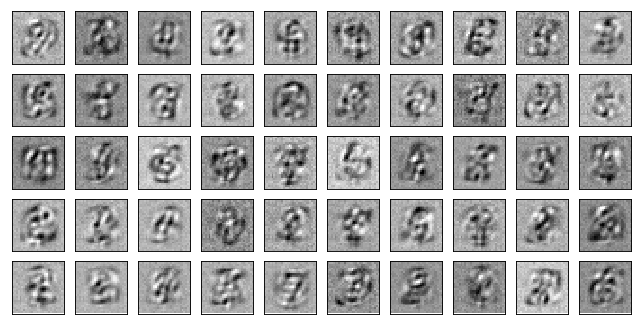

Test losses. model_loss: 0.0437, Discr_loss: 0.0000
0 tensor(0.0423, grad_fn=<AddBackward0>) tensor(1.3161e-07, grad_fn=<MulBackward0>)


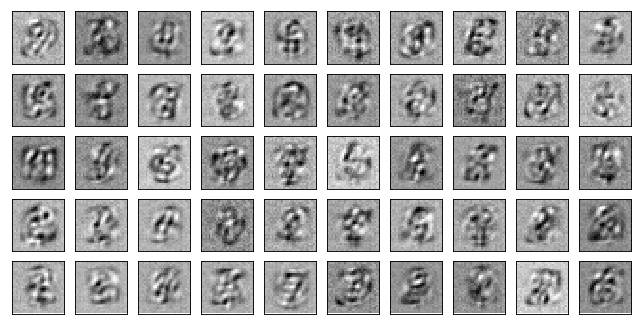

Test losses. model_loss: 0.0433, Discr_loss: 0.0000


In [46]:
for epoch in range(1, 31):
    model.train()
    Discr.train()
    train(epoch, model, Discr, train_log)
    model.eval()
    Discr.eval()
    test(model, Discr, valid_loader, epoch, test_log)